In [ ]:
!pip install jax jaxlib
!pip install --quiet --upgrade scipy
!pip install --quiet jax jaxlib optax

In [ ]:
import jax
from jax.scipy.stats import norm
import jax.numpy as jnp
from scipy.stats import norm
import time
import jax.numpy as jnp
from numpy.polynomial.legendre import leggauss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar, brentq, minimize
from scipy.special import gamma
from numpy.polynomial.legendre import leggauss
import warnings
warnings.filterwarnings('ignore')
from numpy.random import default_rng
from math import log
from numpy.random import default_rng, SeedSequence
from scipy.stats import kstwobign, cramervonmises, uniform
from joblib import Parallel, delayed
from itertools import zip_longest
from collections import OrderedDict


# ==============================================================
# Real Data Analysis
# ==============================================================


In [ ]:


# 1) Load
path = "/content/sample_data/norwegianfire_raw.csv"
df = pd.read_csv(path)
df["year_full"] = 1900 + df["year"].astype(int)

# -------- Choose the cap in NOK -----------------

MONSTER_NOK = 2_000_000_000  # 2 billion NOK   (alternative)

MONSTER_kNOK = MONSTER_NOK / 1_000.0

# 2) Strict threshold: keep claims EXCEEDING 500 kNOK
theta_kNOK = 500.0
df_work = df.loc[df["size"] > theta_kNOK].copy()
n_total = len(df)
n_work  = len(df_work)

# 3) Helper for "nearest" empirical quantile (robust across pandas/numpy versions)
def q_nearest(x: np.ndarray, p: float) -> float:
    x = np.asarray(x, float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return np.nan
    s = pd.Series(x)
    try:
        return float(s.quantile(p, method="nearest"))
    except TypeError:
        try:
            return float(s.quantile(p, interpolation="nearest"))
        except TypeError:
            try:
                return float(np.quantile(x, p, method="nearest"))
            except TypeError:
                return float(np.percentile(x, 100*p, interpolation="nearest"))

# 4) Headline stats (kNOK)
s = df_work["size"].astype(float)
n = s.size
m1 = s.mean()
q1 = q_nearest(s.values, 0.25)
q3 = q_nearest(s.values, 0.75)

# Unbiased (Fisher–Pearson) sample skewness
m2 = np.mean((s - m1)**2)
m3 = np.mean((s - m1)**3)
g1 = m3 / (m2**1.5) if m2 > 0 else np.nan
skew_unbiased = (np.sqrt(n*(n-1))/(n-2))*g1 if n > 2 else np.nan

print("=== Norwegian fire insurance (kNOK), strict > 500 ===")
print(f"n_total: {n_total}")
print(f"n_after_theta (x>500): {n_work}")
print(f"year_min_max: ({int(df['year_full'].min())}, {int(df['year_full'].max())})")
print(f"min_kNOK: {s.min():,.0f}")
print(f"max_kNOK: {s.max():,.0f}")
print(f"mean_kNOK: {m1:,.3f}")
print(f"q1_kNOK: {q1:,.0f}")
print(f"q3_kNOK: {q3:,.0f}")
print(f"skewness: {skew_unbiased:.2f}")

# ---------- Build the four arrays (all in kNOK) ----------
# 1) Original data (x > 500)
x_original = np.asarray(df_work["size"].values, dtype=float)
x_original = np.sort(x_original)

# 2) Modified original: replace the single maximum with MONSTER_kNOK
x_mod_original = x_original.copy()
imax = np.argmax(x_mod_original)
x_mod_original[imax] = MONSTER_kNOK
x_mod_original = np.sort(x_mod_original)

# 3) Sampled: n=50, seed=123
rng = np.random.default_rng(123)
idx50 = rng.choice(x_original.shape[0], size=50, replace=False)
x_sampled = np.sort(x_original[idx50])

# 4) Modified sampled: replace its maximum with MONSTER_kNOK
x_mod_sampled = x_sampled.copy()
jmax = np.argmax(x_mod_sampled)
x_mod_sampled[jmax] = MONSTER_kNOK
x_mod_sampled = np.sort(x_mod_sampled)

# 5) Wire up θ for the ETLL code that uses Greek theta
θ = theta_kNOK

# Quick sanity prints
print(f"\nCounts: {len(x_original)}, {len(x_mod_original)}, {len(x_sampled)}, {len(x_mod_sampled)}")
print(f"Original max -> Modified original max: {np.max(x_original):,.0f} -> {np.max(x_mod_original):,.0f}")
print(f"Sampled max  -> Modified sampled max : {np.max(x_sampled):,.0f}  -> {np.max(x_mod_sampled):,.0f}")
print(f"θ (fixed): {θ:,.0f} kNOK")
print(f"Monster (cap): {MONSTER_kNOK:,.0f} kNOK  = {int(MONSTER_NOK):,} NOK")


=== Norwegian fire insurance (kNOK), strict > 500 ===
n_total: 9181
n_after_theta (x>500): 9020
year_min_max: (1972, 1992)
min_kNOK: 501
max_kNOK: 465,365
mean_kNOK: 2,247.860
q1_kNOK: 711
q3_kNOK: 1,817
skewness: 30.61

Counts: 9020, 9020, 50, 50
Original max -> Modified original max: 465,365 -> 2,000,000
Sampled max  -> Modified sampled max : 4,607  -> 2,000,000
θ (fixed): 500 kNOK
Monster (cap): 2,000,000 kNOK  = 2,000,000,000 NOK


In [ ]:
# ==== Print the sampled values in a 5×10 grid ======

def print_sample_block(x, title, rows=5, cols=10, integers=True):
    """
    Print values as a rows×cols block, left-to-right then top-to-bottom,
    with thousands separators. Assumes len(x) == rows*cols (e.g., 50).
    """
    x = np.sort(np.asarray(x, float))
    if x.size != rows*cols:
        raise ValueError(f"Expected {rows*cols} values, got {x.size}. "
                         f"Adjust rows/cols or sample size.")
    if integers:
        x_disp = np.round(x).astype(int)
        fmt = lambda v: f"{v:,.0f}"
    else:
        x_disp = x
        fmt = lambda v: f"{v:,.3f}"

    print(title)
    for r in range(rows):
        start = r*cols
        row_vals = [fmt(v) for v in x_disp[start:start+cols]]
        print(", ".join(row_vals))
    print()  # blank line after the block

# ---- Print both blocks (kNOK) ----
print_sample_block(x_sampled,      "Sampled data (n=50, kNOK):")
print_sample_block(x_mod_sampled,  "Modified sampled data (n=50, kNOK):")


Sampled data (n=50, kNOK):
505, 512, 513, 520, 541, 615, 632, 641, 650, 650
675, 675, 682, 698, 699, 700, 704, 704, 718, 735
745, 805, 822, 901, 911, 942, 957, 961, 1,035, 1,060
1,075, 1,223, 1,244, 1,343, 1,500, 1,743, 1,750, 2,039, 2,072, 2,097
2,139, 2,220, 2,294, 2,348, 2,468, 2,764, 3,317, 3,814, 4,377, 4,607

Modified sampled data (n=50, kNOK):
505, 512, 513, 520, 541, 615, 632, 641, 650, 650
675, 675, 682, 698, 699, 700, 704, 704, 718, 735
745, 805, 822, 901, 911, 942, 957, 961, 1,035, 1,060
1,075, 1,223, 1,244, 1,343, 1,500, 1,743, 1,750, 2,039, 2,072, 2,097
2,139, 2,220, 2,294, 2,348, 2,468, 2,764, 3,317, 3,814, 4,377, 2,000,000



In [ ]:

# ---- optional: keep BLAS threads = 1 per worker to avoid oversubscription
try:
    from threadpoolctl import threadpool_limits
    _HAS_TPCTL = True
except Exception:
    _HAS_TPCTL = False

# ---------------- Performance knobs ----------------
N_JOBS       = -1       # use all cores
BACKEND      = "loky"   # processes for CPU-bound work
BLAS_THREADS = 1        # 1 BLAS thread per worker

# Numerical effort: high for observed fit, lighter for MC refits
NQUAD_OBS = 800
NQUAD_MC  = 200
GRID_OBS  = 401
GRID_MC   = 201
MC_BATCH  = 200         # chunk MC jobs to lower overhead

# ---- Monte-Carlo reps
# Use big B for full-sample fixed-parameter MC
MC_B_ORIG      = 10000
MC_B_MOD_ORIG  = 10000
# Moderate B for n=50 refitting MC
MC_B_SAMP      = 2000
MC_B_MOD_SAMP  = 2000

ln2 = np.log(2.0)

# ---------- Core ETLL pieces (θ fixed) ----------
def etll_cdf(x, alpha, beta, theta):
    x = np.asarray(x, float)
    u = np.zeros_like(x, dtype=float)
    m = x > theta
    if not np.any(m):
        return u
    t = (theta / x[m])**alpha
    if abs(beta) < 1e-8:
        u[m] = 1.0 - (np.log1p(t) / ln2)
    else:
        two_b = np.exp(beta * ln2)
        u[m] = (two_b - np.power(1.0 + t, beta)) / (two_b - 1.0)
    return np.clip(u, 0.0, 1.0)

def ks_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); ecdf = (np.arange(1, n+1)) / n
    return float(np.max(np.abs(u - ecdf)))

def cvm_statistic(x, cdf):
    x = np.sort(np.asarray(x, float)); n = x.size
    u = cdf(x); i = np.arange(1, n+1)
    return float(np.sum((u - (2*i - 1)/(2*n))**2) + 1.0/(12*n))

def etll_sample(n, alpha, beta, theta, rng=None):
    rng = default_rng() if rng is None else rng
    u = rng.uniform(0.0, 1.0, int(n))
    if abs(beta) < 1e-8:
        t = np.expm1((1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        t     = np.expm1(np.log(base)/beta)
    return theta * np.power(t, -1.0/alpha)

# ---------- MLE (θ fixed) ----------
def etll_loglik_alpha_beta(x, alpha, beta, theta):
    if alpha <= 0 or abs(beta) > 12:
        return -np.inf
    xv = np.asarray(x, float); xv = xv[xv > theta]
    if xv.size == 0:
        return -np.inf
    n = xv.size
    two_b = np.exp(beta * ln2)
    denom = two_b - 1.0
    if abs(denom) < 1e-14:
        denom = beta * ln2 + 0.5*(beta**2)*(ln2**2)
    const = np.log(alpha) + np.log(abs(beta)) - np.log(abs(denom))
    ratio = (theta / xv)**alpha
    ll = n*const - np.sum(np.log(xv)) + np.sum(alpha*np.log(theta/xv)) + (beta-1.0)*np.sum(np.log1p(ratio))
    return float(ll)

def fit_mle_etll(x, theta):
    x = np.asarray(x, float); x = x[x > theta]
    if x.size < 5:
        return np.nan, np.nan
    lx = np.log(x); m2 = np.mean((lx - lx.mean())**2)
    a0 = max(0.1, 1.0/np.sqrt(max(m2, 1e-6))); b0 = 0.5
    def nll(p):
        a,b = p; v = etll_loglik_alpha_beta(x, a, b, theta)
        return -v if np.isfinite(v) else 1e20
    res = minimize(nll, x0=[a0, b0], bounds=[(1e-3, 40.0), (-12.0, 12.0)], method="L-BFGS-B")
    if res.success:
        return float(res.x[0]), float(res.x[1])
    res = minimize(nll, x0=[1.5, 0.2], bounds=[(1e-3, 40.0), (-12.0, 12.0)], method="L-BFGS-B")
    return (float(res.x[0]), float(res.x[1])) if res.success else (np.nan, np.nan)

# ---------- Robust L-estimation J(a,b) (θ fixed) ----------
def _ck_tau(beta, a, b, n_quad):
    nodes, w = np.polynomial.legendre.leggauss(n_quad)
    u = 0.5*(nodes + 1.0); w = 0.5*w
    J = a*b * (u**(a-1.0)) * ((1.0 - u**a)**(b-1.0))

    if abs(beta) < 1e-10:
        t = np.expm1((1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = two_b - (two_b - 1.0) * u
        base  = np.maximum(base, 1e-300)
        t     = np.expm1(np.log(base)/beta)

    t   = np.maximum(t, 1e-300)
    ell = np.log(t)

    c1  = float(np.sum(w * J * ell))
    c2  = float(np.sum(w * J * (ell**2)))
    tau = c2 - c1**2
    return c1, max(tau, 1e-14)

def fit_L_etll_stable(x, a=1.1, b=1.2, theta=500.0, n_quad=NQUAD_OBS, root_grid=GRID_OBS):
    x = np.asarray(x, float); x = x[x > theta]
    n = x.size
    if n < 5:
        return np.nan, np.nan

    xs  = np.sort(x)
    i   = np.arange(1, n+1)
    uo  = i/(n+1.0)

    Jw  = a*b * (uo**(a-1.0)) * ((1.0 - uo**a)**(b-1.0))
    wts = Jw / np.sum(Jw)

    lx = np.log(xs)
    mu1   = float(np.sum(wts * lx))
    mu2   = float(np.sum(wts * (lx**2)))
    Delta = max(mu2 - mu1**2, 1e-12)

    target = (np.log(theta) - mu1) / np.sqrt(Delta)

    def R(beta):
        c1, tau = _ck_tau(beta, a, b, n_quad=n_quad)
        return c1/np.sqrt(tau) - target

    grid = np.linspace(-10.0, 10.0, int(root_grid))
    vals = np.array([R(bi) for bi in grid])
    sgn  = np.sign(vals)

    beta_hat = None
    for k in range(len(grid)-1):
        if np.isfinite(vals[k]) and np.isfinite(vals[k+1]) and sgn[k]*sgn[k+1] < 0:
            beta_hat = brentq(lambda z: R(z), grid[k], grid[k+1], xtol=1e-8, maxiter=400)
            break

    if beta_hat is None:
        from scipy.optimize import minimize_scalar
        obj = lambda b: (R(b) if np.isfinite(R(b)) else 1e6)**2
        res = minimize_scalar(obj, bounds=(-10.0, 10.0), method="bounded",
                              options={"xatol":1e-8, "maxiter":1000})
        beta_hat = float(res.x)

    _, tau_hat = _ck_tau(beta_hat, a, b, n_quad=n_quad)
    alpha_hat  = np.sqrt(tau_hat / Delta)
    return float(alpha_hat), float(beta_hat)

def make_safe_L_factory(a_req, b_req, fallbacks=None, n_quad=NQUAD_OBS, root_grid=GRID_OBS):
    if fallbacks is None:
        fallbacks = [(1.05,1.10), (1.10,1.20), (1.20,1.30)]
    def fit_fun(z, _nq=n_quad, _rg=root_grid):
        ah, bh = fit_L_etll_stable(z, a_req, b_req, θ, n_quad=_nq, root_grid=_rg)
        if np.isfinite(ah) and np.isfinite(bh):
            return ah, bh
        for (aa,bb) in fallbacks:
            ah2, bh2 = fit_L_etll_stable(z, aa, bb, θ, n_quad=_nq, root_grid=_rg)
            if np.isfinite(ah2) and np.isfinite(bh2):
                return ah2, bh2
        return fit_mle_etll(z, θ)
    return fit_fun

# ---- MC p-values with RE-FITTING (n=50 panels)
def mc_pvals_parallel(x, fit_fun, theta, B=2000, seed=1234, n_jobs=N_JOBS, backend=BACKEND,
                      nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC, grid_obs=GRID_OBS, grid_mc=GRID_MC,
                      batch=MC_BATCH):
    if _HAS_TPCTL: threadpool_limits(BLAS_THREADS)
    x = np.asarray(x, float); x = x[x > theta]
    n = x.size
    if n == 0: return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    def fit_obs(z): return fit_fun(z, _nq=nquad_obs, _rg=grid_obs)
    a_hat, b_hat = fit_obs(x)
    cdf_hat = lambda z: etll_cdf(z, a_hat, b_hat, theta)
    D_obs = ks_statistic(x, cdf_hat); W_obs = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = etll_sample(n, a_hat, b_hat, theta, rng)
        ah, bh = fit_fun(xb, _nq=nquad_mc, _rg=grid_mc)
        cdf_b = lambda z, aa=ah, bb=bh: etll_cdf(z, aa, bb, theta)
        return ks_statistic(xb, cdf_b), cvm_statistic(xb, cdf_b)

    def _chunks(lst, k):
        for i in range(0, len(lst), k): yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, MC_BATCH):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds)); Ws_all.append(np.array(Ws))
    Ds = np.concatenate(Ds_all); Ws = np.concatenate(Ws_all)

    # Davison–Hinkley
    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

# ---- MC p-values with FIXED PARAMETERS
def mc_pvals_fixedparams(x, fit_fun, theta, B=10000, seed=1234, n_jobs=N_JOBS, backend=BACKEND,
                         nquad_obs=NQUAD_OBS, batch=MC_BATCH):
    if _HAS_TPCTL: threadpool_limits(BLAS_THREADS)
    x = np.asarray(x, float); x = x[x > theta]
    n = x.size
    if n == 0: return (np.nan, np.nan, np.nan, np.nan, np.nan, np.nan)

    # Fit once (full accuracy), then DO NOT refit in replicates
    a_hat, b_hat = fit_fun(x, _nq=nquad_obs, _rg=GRID_OBS)
    cdf_hat = lambda z: etll_cdf(z, a_hat, b_hat, theta)
    D_obs = ks_statistic(x, cdf_hat); W_obs = cvm_statistic(x, cdf_hat)

    seeds = SeedSequence(seed).spawn(B)
    seed_ints = [int(s.generate_state(1)[0]) for s in seeds]

    def one_rep(seed_i):
        rng = default_rng(seed_i)
        xb = etll_sample(n, a_hat, b_hat, theta, rng)
        # NO refit here:
        return ks_statistic(xb, cdf_hat), cvm_statistic(xb, cdf_hat)

    def _chunks(lst, k):
        for i in range(0, len(lst), k): yield lst[i:i+k]

    Ds_all, Ws_all = [], []
    for chunk in _chunks(seed_ints, batch):
        Ds, Ws = zip(*Parallel(n_jobs=n_jobs, backend=backend)(
            delayed(one_rep)(si) for si in chunk
        ))
        Ds_all.append(np.array(Ds)); Ws_all.append(np.array(Ws))
    Ds = np.concatenate(Ds_all); Ws = np.concatenate(Ws_all)

    p_ks  = (1.0 + np.sum(Ds >= D_obs)) / (B + 1.0)
    p_cvm = (1.0 + np.sum(Ws >= W_obs)) / (B + 1.0)
    return (a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm)

# ---------- GoF with selectable mode ----------
def gof_with_mode(x, fit_fun, mode="mc", B=100, seed=1234, n_jobs=N_JOBS):
    x = np.asarray(x, float); x = x[x > θ]
    if x.size == 0:
        return {"Estimator":"", "alpha":np.nan, "beta":np.nan,
                "KS_p":np.nan, "KS_D":np.nan, "CvM_p":np.nan, "CvM_W":np.nan,
                "_det":1.0/(B+1.0)}

    if mode == "mc_fixed":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_fixedparams(
            x, fit_fun, θ, B=B, seed=seed, n_jobs=n_jobs, nquad_obs=NQUAD_OBS, batch=MC_BATCH
        )
        return {"Estimator":"", "alpha":a_hat, "beta":b_hat,
                "KS_p":p_ks, "KS_D":D_obs, "CvM_p":p_cvm, "CvM_W":W_obs,
                "_det":1.0/(B+1.0)}

    if mode == "mc":
        a_hat, b_hat, D_obs, W_obs, p_ks, p_cvm = mc_pvals_parallel(
            x, fit_fun, θ, B=B, seed=seed, n_jobs=n_jobs,
            nquad_obs=NQUAD_OBS, nquad_mc=NQUAD_MC, grid_obs=GRID_OBS, grid_mc=GRID_MC
        )
        return {"Estimator":"", "alpha":a_hat, "beta":b_hat,
                "KS_p":p_ks, "KS_D":D_obs, "CvM_p":p_cvm, "CvM_W":W_obs,
                "_det":1.0/(B+1.0)}

    # asymptotic (not used here)
    a_hat, b_hat = fit_fun(x)
    cdf_hat = lambda z: etll_cdf(z, a_hat, b_hat, θ)
    D_obs = ks_statistic(x, cdf_hat)
    W_obs = cvm_statistic(x, cdf_hat)
    p_ks  = float(kstwobign.sf(np.sqrt(x.size) * D_obs))
    u = etll_cdf(np.sort(x), a_hat, b_hat, θ)
    p_cvm = float(cramervonmises(u, uniform.cdf).pvalue)
    return {"Estimator":"", "alpha":a_hat, "beta":b_hat,
            "KS_p":p_ks, "KS_D":D_obs, "CvM_p":p_cvm, "CvM_W":W_obs,
            "_det":0.0}

# ---------- Build panel ----------
def build_panel(x, estimators, mode="mc", B=100, seed=1234, n_jobs=N_JOBS):
    rows = []
    for (name, fit_fun) in estimators:
        r = gof_with_mode(x, fit_fun, mode=mode, B=B, seed=seed, n_jobs=n_jobs)
        r["Estimator"] = name
        rows.append(r)
    return rows

# ---------- Printing (with spanner headers) ----------
def _panel_to_lines_with_spanner(title, rows):
    # widths: widen p columns to allow "<0.001"
    w = dict(est=16, a=6, b=7, pks=10, dks=8, pcvm=10, wcvm=9)

    def pad(s, width, align="<"):
        return f"{s:{align}{width}}"

    def fmt_p(p, det):
        return f"<{det:.3f}" if (det > 0 and p <= det) else f"{p:.3f}"

    det = rows[0].get("_det", 0.0) if rows else 0.0

    lines = [title]

    # spanner row
    top = (
        pad("Estimator", w["est"]) +
        pad("α̂",        w["a"],  ">") +
        pad("β̂",        w["b"],  ">") +
        pad("KS Test",   w["pks"] + w["dks"], ">") +
        pad("CvM",       w["pcvm"] + w["wcvm"], ">")
    )
    # subheader row
    sub = (
        pad("",          w["est"]) +
        pad("",          w["a"]) +
        pad("",          w["b"]) +
        pad("p",         w["pks"], ">") +
        pad("D",         w["dks"], ">") +
        pad("p",         w["pcvm"], ">") +
        pad("W",         w["wcvm"], ">")
    )
    lines += [top, sub]

    # data rows
    for r in rows:
        lines.append(
            pad(r["Estimator"],         w["est"]) +
            pad(f"{r['alpha']:.2f}",    w["a"],  ">") +
            pad(f"{r['beta']:.2f}",     w["b"],  ">") +
            pad(fmt_p(r["KS_p"], det),  w["pks"], ">") +
            pad(f"{r['KS_D']:.3f}",     w["dks"], ">") +
            pad(fmt_p(r["CvM_p"], det), w["pcvm"], ">") +
            pad(f"{r['CvM_W']:.3f}",    w["wcvm"], ">")
        )
    return lines

def print_side_by_side_with_spanners(left_title, left_rows, right_title, right_rows):
    L = _panel_to_lines_with_spanner(left_title, left_rows)
    R = _panel_to_lines_with_spanner(right_title, right_rows)
    gap = 3
    left_width = max(len(s) for s in L) + gap
    total_width = left_width + max(len(s) for s in R)
    rule = "=" * total_width
    print("\n" + rule)
    for l, r in zip_longest(L, R, fillvalue=""):
        print(f"{l:<{left_width}}{r}")
    print(rule)

# ---------- Estimators ----------
estimators_orig = [
    ("MLE",          lambda z, **kw: fit_mle_etll(z, θ)),
    ("J(1.30,1.60)", make_safe_L_factory(1.30, 1.60)),
]
estimators_samp = [
    ("MLE",            lambda z, **kw: fit_mle_etll(z, θ)),
    ("J(1.30,1.40)",   make_safe_L_factory(1.30, 1.40,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.25,2.00)",   make_safe_L_factory(1.25, 2.00,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(1.50,1.60)",   make_safe_L_factory(1.50, 1.60,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.00,2.00)",   make_safe_L_factory(1.00, 2.00,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(1.35,3.50)",   make_safe_L_factory(1.35, 3.50,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.25,9.00)",   make_safe_L_factory(1.25, 9.00,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(1.40,1.40)",   make_safe_L_factory(1.40, 1.40,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.30,1.60)",   make_safe_L_factory(1.30, 1.60,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(0.80,2.00)",   make_safe_L_factory(0.80, 2.00,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),
    ("J(2.00,0.80)",   make_safe_L_factory(2.00, 0.80,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.20,1.30)])),
    ("J(1.15,4.00)",   make_safe_L_factory(1.15, 4.00,
                           fallbacks=[(1.05,1.10),(1.10,1.20),(1.30,1.40)])),

]

# ---------- Build panels ----------
t0 = time.perf_counter()  # ⏱ start

# Full-sample panels: FIXED-PARAMETER MC
panel_original   = build_panel(x_original,     estimators_orig, mode="mc_fixed",
                               B=MC_B_ORIG,     seed=2025, n_jobs=N_JOBS)
panel_mod_orig   = build_panel(x_mod_original, estimators_orig, mode="mc_fixed",
                               B=MC_B_MOD_ORIG, seed=2026, n_jobs=N_JOBS)

# n=50 panels: RE-FITTING MC
panel_sampled    = build_panel(x_sampled,      estimators_samp, mode="mc",
                               B=MC_B_SAMP,     seed=2027, n_jobs=N_JOBS)
panel_mod_sample = build_panel(x_mod_sampled,  estimators_samp, mode="mc",
                               B=MC_B_MOD_SAMP, seed=2028, n_jobs=N_JOBS)

# ---------- Print side-by-side ----------
print_side_by_side_with_spanners(
    "Original Data (θ = 500)", panel_original,
    "Modified Original Data ", panel_mod_orig
)
print_side_by_side_with_spanners(
    "Sampled Data (n=50)", panel_sampled,
    "Modified Sampled Data", panel_mod_sample
)
print(f"\n⏱️ Block runtime: {time.perf_counter() - t0:.2f} s")  # ⏱ end


Original Data (θ = 500)                                              Modified Original Data 
Estimator           α̂     β̂           KS Test                CvM   Estimator           α̂     β̂           KS Test                CvM
                                      p       D         p        W                                         p       D         p        W
MLE               1.49  -1.06     0.095   0.013     0.131    0.310   MLE               1.49  -1.06     0.087   0.013     0.123    0.314
J(1.30,1.60)      1.49  -1.03     0.098   0.013     0.145    0.296   J(1.30,1.60)      1.49  -1.03     0.092   0.013     0.136    0.296

Sampled Data (n=50)                                                  Modified Sampled Data
Estimator           α̂     β̂           KS Test                CvM   Estimator           α̂     β̂           KS Test                CvM
                                      p       D         p        W                                         p       D         p        

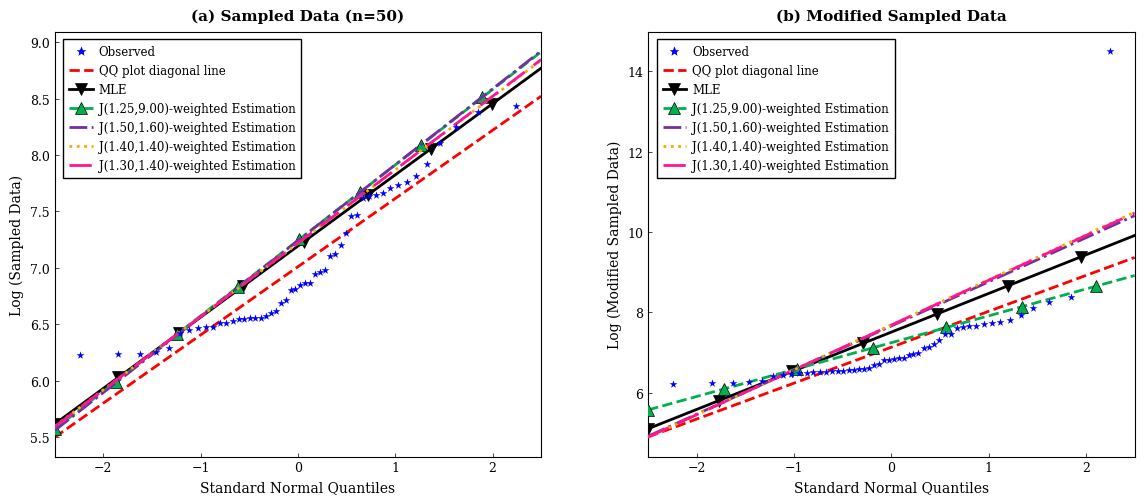


⏱️ Figure block runtime: 363.79 s


In [ ]:
# -------------------- Style --------------------
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.labelsize': 10,
    'axes.titlesize': 11,
    'legend.fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'axes.linewidth': 0.8,
    'lines.linewidth': 1.5,
    'lines.markersize': 6,
    'axes.grid': False,   # no gray grid
})

# -------------------- ETLL quantile --------------------
ln2 = np.log(2.0)
def etll_ppf(u, alpha, beta, theta):
    u = np.clip(np.asarray(u, float), 1e-12, 1-1e-12)
    if abs(beta) < 1e-10:
        t = np.expm1((1.0 - u) * ln2)
    else:
        two_b = np.exp(beta * ln2)
        base  = np.maximum(two_b - (two_b - 1.0) * u, 1e-300)
        t     = np.expm1(np.log(base)/beta)
    return theta * np.power(np.maximum(t, 1e-300), -1.0/alpha)

# -------------------- Fixed picks from table --------------------
MODELS_SAMPLED = [
    ("MLE",           lambda z: fit_mle_etll(z, θ)),
    ("J(1.25,9.00)",  make_safe_L_factory(1.25, 9.00)),
    ("J(1.50,1.60)",  make_safe_L_factory(1.50, 1.60)),
    ("J(1.40,1.40)",  make_safe_L_factory(1.40, 1.40)),
    ("J(1.30,1.40)",  make_safe_L_factory(1.30, 1.40)),
]
MODELS_MODIFIED = [
    ("MLE",           lambda z: fit_mle_etll(z, θ)),
    ("J(1.25,9.00)",  make_safe_L_factory(1.25, 9.00)),  # BEST1
    ("J(1.50,1.60)",  make_safe_L_factory(1.50, 1.60)),  # BEST2
    ("J(1.40,1.40)",  make_safe_L_factory(1.40, 1.40)),  # BEST3
    ("J(1.30,1.40)",  make_safe_L_factory(1.30, 1.40)),  # BEST4
]

# -------------------- House style map (UPDATED TO MATCH IMAGE) --------------------
STYLE_ORDER = ["MLE", "BEST1", "BEST2", "BEST3", "BEST4"]
STYLE_MAP = {
    "MLE":   dict(color="black",   linestyle="-",      linewidth=2.0, marker="v",
                  markersize=8, markevery=0.12, markeredgewidth=0.5, markeredgecolor='black',
                  label="MLE"),
    "BEST1": dict(color="#00B050",  linestyle="--",    linewidth=2.0, marker="^",
                  markersize=8, markevery=0.12, markeredgewidth=0.5, markeredgecolor='black',
                  label_fmt=lambda n: f"{n}-weighted Estimation"),     # bright green
    "BEST2": dict(color="#7030A0",  linestyle="-.",    linewidth=2.0, marker=None,
                  label_fmt=lambda n: f"{n}-weighted Estimation"),     # purple
    "BEST3": dict(color="#FFA500",  linestyle=":",     linewidth=2.0, marker=None,
                  label_fmt=lambda n: f"{n}-weighted Estimation"),     # orange
    "BEST4": dict(color="#FF1493",  linestyle=(0,(8,4)), linewidth=2.0, marker=None,
                  label_fmt=lambda n: f"{n}-weighted Estimation"),     # pink
}

# -------------------- Helpers for straight proxy lines --------------------
from scipy.stats import norm

def blom_positions(n: int):
    """Blom plotting positions (gentler tails than i/(n+1))."""
    i = np.arange(1, n+1)
    return (i - 0.375) / (n + 0.25)

def model_proxy_line(alpha, beta, theta, z_min=-2.5, z_max=2.5, m=400):
    """
    Best straight line A + B z approximating log q_model(p) vs z on [z_min,z_max].
    """
    z_grid = np.linspace(z_min, z_max, m)
    p_grid = norm.cdf(z_grid)
    q_grid = etll_ppf(p_grid, alpha, beta, theta)
    y_grid = np.log(q_grid)
    B, A = np.polyfit(z_grid, y_grid, 1)  # slope, intercept
    return A, B

# -------------------- Panel (uses straight proxy lines for fits) --------------------
def qq_panel(ax, x, model_list, panel_title, y_label):
    x = np.sort(np.asarray(x, float))
    n = x.size

    # Points: Blom positions -> normal quantiles
    u = blom_positions(n)
    z = norm.ppf(u)
    y_obs = np.log(x)

    # Observed points (blue stars)
    ax.scatter(z, y_obs, s=35, alpha=1.0, color='blue', marker='*',
               label='Observed', zorder=5, linewidth=0)

    # Data "QQ diagonal": OLS line through (z, log x)
    B_data, A_data = np.polyfit(z, y_obs, 1)  # slope, intercept
    z_line = np.linspace(-2.5, 2.5, 200)      # fixed range for both panels
    ax.plot(z_line, A_data + B_data*z_line, '--', linewidth=2.0, color='red',
            zorder=2, label='QQ plot diagonal line')

    # Model overlays: straight proxy lines
    legend_handles, legend_labels = [], []
    for idx, (name, fit_fun) in enumerate(model_list):
        a_hat, b_hat = fit_fun(x)
        if not (np.isfinite(a_hat) and np.isfinite(b_hat)):
            continue

        style_key = STYLE_ORDER[idx] if idx < len(STYLE_ORDER) else "BEST4"
        st = STYLE_MAP[style_key]

        A_m, B_m = model_proxy_line(a_hat, b_hat, θ, z_line.min(), z_line.max())

        # Plot the line with markers if specified
        line_kwargs = {
            'color': st['color'],
            'linestyle': st['linestyle'],
            'linewidth': st['linewidth'],
            'zorder': 3
        }

        # Add marker properties if marker is specified
        if st.get('marker') is not None:
            line_kwargs.update({
                'marker': st['marker'],
                'markersize': st.get('markersize', 8),
                'markevery': st.get('markevery', 0.12),
                'markeredgewidth': st.get('markeredgewidth', 0.5),
                'markeredgecolor': st.get('markeredgecolor', 'black'),
                'markerfacecolor': st['color']
            })

        line = ax.plot(z_line, A_m + B_m*z_line, **line_kwargs)[0]

        # Build label
        if 'label' in st:
            label = st['label']
        else:
            label = st['label_fmt'](name)

        legend_handles.append(line)
        legend_labels.append(label)

    # Cosmetics
    ax.set_title(panel_title, fontsize=11, fontweight='bold', pad=8)
    ax.set_xlabel("Standard Normal Quantiles", fontsize=10)
    ax.set_ylabel(y_label, fontsize=10)
    ax.grid(False)
    ax.set_facecolor('white')
    ax.tick_params(direction='in', length=3, width=0.5)
    ax.set_axisbelow(True)
    ax.set_xlim(z_line.min(), z_line.max())
    for spine in ax.spines.values():
        spine.set_edgecolor('black'); spine.set_linewidth(0.8)

    # Legend
    obs_handle  = plt.Line2D([0], [0], marker='*', color='w', markerfacecolor='blue',
                             markersize=10, linestyle='', label='Observed')
    diag_handle = plt.Line2D([0], [0], color='red', linewidth=2.0,
                             linestyle='--', label='QQ plot diagonal line')
    all_handles = [obs_handle, diag_handle] + legend_handles
    all_labels  = ['Observed', 'QQ plot diagonal line'] + legend_labels
    ax.legend(all_handles, all_labels,
              loc='upper left', bbox_to_anchor=(0.01, 0.99),
              fontsize=8.5, frameon=True, fancybox=False, framealpha=1.0,
              edgecolor='black', borderpad=0.5, columnspacing=1.0,
              handletextpad=0.5, borderaxespad=0.3)

# -------------------- Two-panel figure --------------------
t0 = time.perf_counter()  # ⏱ start

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.patch.set_facecolor('white')
plt.subplots_adjust(left=0.08, right=0.98, top=0.95, bottom=0.1, wspace=0.22)

qq_panel(axes[0], x_sampled,     MODELS_SAMPLED,
         "(a) Sampled Data (n=50)", "Log (Sampled Data)")
qq_panel(axes[1], x_mod_sampled, MODELS_MODIFIED,
         "(b) Modified Sampled Data", "Log (Modified Sampled Data)")

for fmt, dpi in [('pdf', None), ('png', 300),('eps', 300)]:
    plt.savefig(f'fig_style_ETELL_manyL.{fmt}', format=fmt, dpi=dpi,
                bbox_inches='tight', facecolor='white', edgecolor='white')
plt.show()

print(f"\n⏱️ Figure block runtime: {time.perf_counter() - t0:.2f} s")